# Test For `DriftCheckerEstimator`-`pydrift` 

We're going to test how it works with the famous titanic dataset

# Dependencies

In [1]:
import pandas as pd

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

from pydrift import DriftCheckerEstimator
from pydrift.exceptions import ColumnsNotMatchException
from pydrift.constants import PATH_DATA, RANDOM_STATE
from pydrift.models import cat_features_fillna
from pydrift.exceptions import DriftEstimatorException


set_config(display='diagram')

# Read Data 

In [2]:
df_titanic = pd.read_csv(PATH_DATA / 'titanic.csv')

# Constants 

In [3]:
DATA_LENGTH = df_titanic.shape[0]
TARGET = 'Survived'

# Data Split

50% sample will give us a non-drift problem

We drop Ticket and Cabin features because of cardinality

In [4]:
X = df_titanic.drop(columns=['Ticket', 'Cabin', 'PassengerId', 'Name', TARGET])
y = df_titanic[TARGET]

cat_features = (X
                .select_dtypes(include=['category', 'object'])
                .columns)

X_filled = cat_features_fillna(X, cat_features)

X_train_filled, X_test_filled, y_train, y_test = train_test_split(
    X_filled, y, test_size=.5, random_state=RANDOM_STATE, stratify=y
)

catboost_classifier = CatBoostClassifier(
    num_trees=5,
    max_depth=3,
    cat_features=cat_features,
    random_state=RANDOM_STATE,
    verbose=False
)

# Build Pipeline With DriftCheckerEstimator

Catboost as estimator

In [5]:
pipeline_catboost_drift_checker = make_pipeline(
    DriftCheckerEstimator(ml_classifier_model=catboost_classifier, column_names=X.columns)
)

display(pipeline_catboost_drift_checker)

Pipeline(steps=[('driftcheckerestimator',
                 DriftCheckerEstimator(column_names=Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object'),
                                       ml_classifier_model=<catboost.core.CatBoostClassifier object at 0x7f9718f77908>))])

# Let´s Fit And Predict

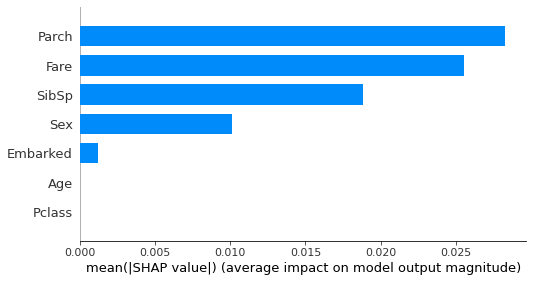

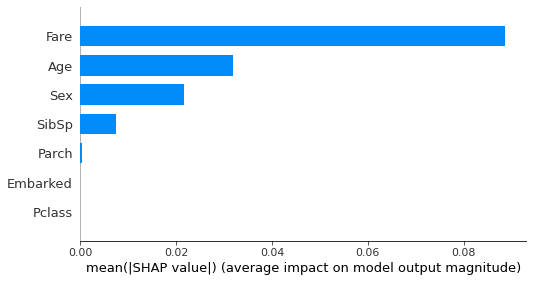

AUC training data: 0.86
AUC testing data: 0.84


In [6]:
pipeline_catboost_drift_checker.fit(X_train_filled, y_train)

y_score_train = pipeline_catboost_drift_checker.predict_proba(X_train_filled)[:, 1]
y_score_test = pipeline_catboost_drift_checker.predict_proba(X_test_filled)[:, 1]

auc_train = roc_auc_score(y_true=y_train, y_score=y_score_train)
auc_test = roc_auc_score(y_true=y_test, y_score=y_score_test)

print(f'AUC training data: {auc_train:.2f}')
print(f'AUC testing data: {auc_test:.2f}')

# Same With Logistic Regression Pipeline 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.5, random_state=RANDOM_STATE, stratify=y
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder()
)

column_transformer = make_column_transformer(
    (categorical_pipeline, cat_features),
    (SimpleImputer(strategy='median'), X_train.select_dtypes(include='number').columns)
)

pipeline_lr_drift_checker = make_pipeline(
    column_transformer,
    DriftCheckerEstimator(
        ml_classifier_model=LogisticRegression(max_iter=1000,
                                               random_state=RANDOM_STATE),
        column_names=X.columns
    )
)

display(pipeline_lr_drift_checker)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  Index(['Sex', 'Embarked'], dtype='object')),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object'))])),
                ('driftcheckerestimator',
                 DriftCheckerEstimator(column_names=Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object'),
                                       ml_classifier_model=LogisticRegression(max_iter=1000,
                                                                              random_state=1994)))])

# Let´s Fit And Predict 

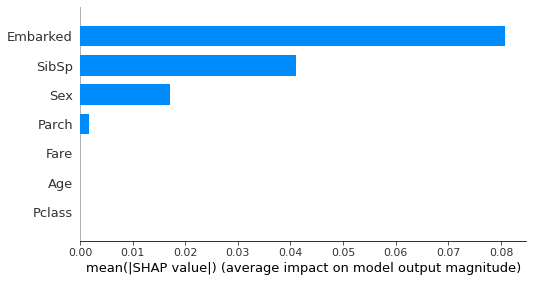

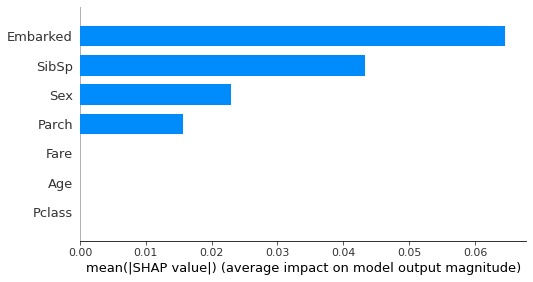

AUC training data: 0.851
AUC testing data: 0.855


In [8]:
pipeline_lr_drift_checker.fit(X_train, y_train)

y_score_train = pipeline_lr_drift_checker.predict_proba(X_train)[:, 1]
y_score_test = pipeline_lr_drift_checker.predict_proba(X_test)[:, 1]

auc_train = roc_auc_score(y_true=y_train, y_score=y_score_train)
auc_test = roc_auc_score(y_true=y_test, y_score=y_score_test)

print(f'AUC training data: {auc_train:.3f}')
print(f'AUC testing data: {auc_test:.3f}')

# Ok, Now With Drifted Data 

In [9]:
X = df_titanic.drop(columns=['Ticket', 'Cabin', 'PassengerId', 'Name', TARGET])
y = df_titanic[TARGET]

cat_features = (X
                .select_dtypes(include=['category', 'object'])
                .columns)

X_filled = cat_features_fillna(X, cat_features)

X_train_filled, X_test_filled, y_train, y_test = train_test_split(
    X_filled, y, test_size=.5, random_state=RANDOM_STATE, stratify=y
)

df_train_filled = pd.concat([X_train_filled, y_train], axis=1)
df_train_filled_drifted = df_train_filled[(df_train_filled['Pclass'] > 1) & (df_train_filled['Fare'] > 10)].copy()

X_train_filled_drifted = df_train_filled_drifted.drop(columns=TARGET)
y_train_filled_drifted = df_train_filled_drifted[TARGET]

df_test_filled = pd.concat([X_test_filled, y_test], axis=1)
df_test_filled_drifted = df_test_filled[~(df_test_filled['Pclass'] > 1) & (df_test_filled['Fare'] > 10)].copy()

X_test_filled_drifted = df_test_filled_drifted.drop(columns=TARGET)
y_test_filled_drifted = df_test_filled_drifted[TARGET]

# Let´s Try To Fit And Predict 

DriftEstimatorException tells you that there are some data drifts, you can acces to `drifted_columns` attribute to ckeck them, we will do in the next cell

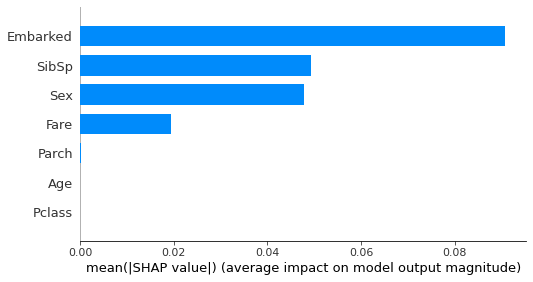

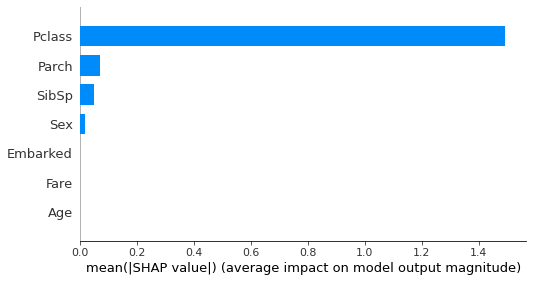

Drift found in numerical columns check step
Drift found in categorical columns check step
Drift found in discriminative model step
Drift found in pipeline_catboost_drift_checker


In [10]:
pipeline_catboost_drift_checker.fit(X_train_filled_drifted, y_train_filled_drifted)

y_score_train = pipeline_catboost_drift_checker.predict_proba(X_train_filled_drifted)[:, 1]

try:
    y_score_test = pipeline_catboost_drift_checker.predict_proba(X_test_filled_drifted)[:, 1]

    auc_train = roc_auc_score(y_true=y_train_filled_drifted, y_score=y_score_train)
    auc_test = roc_auc_score(y_true=y_test_filled_drifted, y_score=y_score_test)

    print(f'AUC training data: {auc_train:.2f}')
    print(f'AUC testing data: {auc_test:.2f}')
except DriftEstimatorException:
    print('Drift found in pipeline_catboost_drift_checker')

# `Embarked` Is The Drifted Feature

In [11]:
drifted_features = (
    pipeline_catboost_drift_checker
    .named_steps['driftcheckerestimator']
    .get_drifted_features()
)

drifted_features

'Pclass, Age, Parch, Fare'

# You Can Also Get High Cardinality Features

None in this case

In [12]:
(
    pipeline_catboost_drift_checker
    .named_steps['driftcheckerestimator']
    .get_high_cardinality_features()
)

''